In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as patch

import cv2
from skimage.draw import circle
from skimage import morphology as mp
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage import measure, segmentation, morphology
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

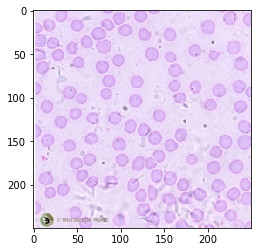

In [24]:
CELL = cv2.imread("CELLS.jpg")
plt.imshow(CELL, cmap = 'gray')

https://www.amazon.com/Human-Blood-Slide-Smear-Wrights/dp/B005XCVMZ2


In [10]:
def Parametric_Segmentation(img, ROI):
    

    img = img/255
    ROI = ROI/255

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    I = R+G+B

    I[I==0] = 10

    r = R/I
    g = G/I

    ROI_R = ROI[:,:,0]
    ROI_G = ROI[:,:,1]
    ROI_B = ROI[:,:,2]

    ROI_I = ROI_R+ROI_G+ROI_B
    ROI_r = ROI_R/ROI_I
    ROI_g = ROI_G/ROI_I

    mu_r, std_r = np.mean(ROI_r), np.std(ROI_r)
    mu_g, std_g = np.mean(ROI_g), np.std(ROI_g)

    P_r = (1/(std_r*np.sqrt(2*np.pi))) * (np.exp(-(r-mu_r)**2/(2*std_r**2)))
    P_g = (1/(std_r*np.sqrt(2*np.pi))) * (np.exp(-(g-mu_g)**2/(2*std_g**2)))
    
    return P_r*P_g

def Non_Parametric_Segmentation(img,ROI, BINS):

    img = img/255
    ROI = ROI/255

    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    I = R+G+B

    I[I==0] = 10

    r = R/I
    g = G/I

    ROI_R = ROI[:,:,0]
    ROI_G = ROI[:,:,1]
    ROI_B = ROI[:,:,2]

    ROI_I = ROI_R+ROI_G+ROI_B
    ROI_r = ROI_R/ROI_I
    ROI_g = ROI_G/ROI_I

    r_roi_int = (ROI_r*(BINS-1)).astype(int)
    g_roi_int = (ROI_g*(BINS-1)).astype(int)
    
    matrix, xbin, ybin = np.histogram2d(g_roi_int.flatten(), r_roi_int.flatten(), bins = BINS, range = [[0,BINS],[0,BINS]])
    r_int, g_int = (r*(BINS-1)).astype(int), (g*(BINS-1)).astype(int)
    
    back_projection = np.zeros(r.shape)
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            back_projection[i,j] = matrix[g_int[i,j], r_int[i,j]]
    
    return back_projection



In [118]:
def Segmentation(image, BINS):
    r = cv2.selectROI(image)
    ROI = image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    plt.figure(figsize = [20,10], facecolor = "white")
    plt.rcParams.update({'font.size' : 15})
    plt.rcParams['axes.titlesize'] = 15
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Original")
    plt.subplot(1,3,2)
    Par = Parametric_Segmentation(image, ROI)
    plt.imshow(Par, cmap = 'gray')
    plt.title("Parametric")
    plt.subplot(1,3,3)
    NPar = Non_Parametric_Segmentation(image, ROI,BINS)
    plt.imshow(NPar, cmap = 'gray')
    plt.title("Non-parametric (bin size = " + str(BINS) + ")")
    
    return Par/np.amax(Par), NPar/np.max(NPar)
    

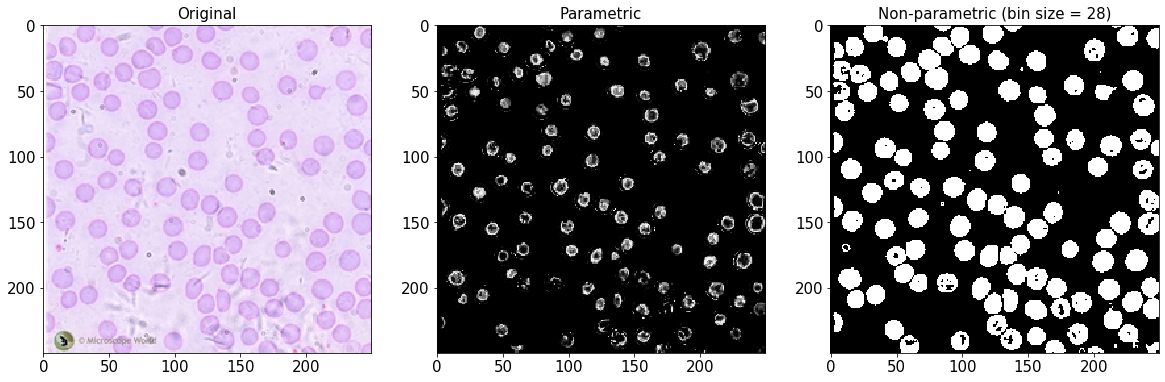

In [119]:
Par, NPar = Segmentation(CELL, 28)

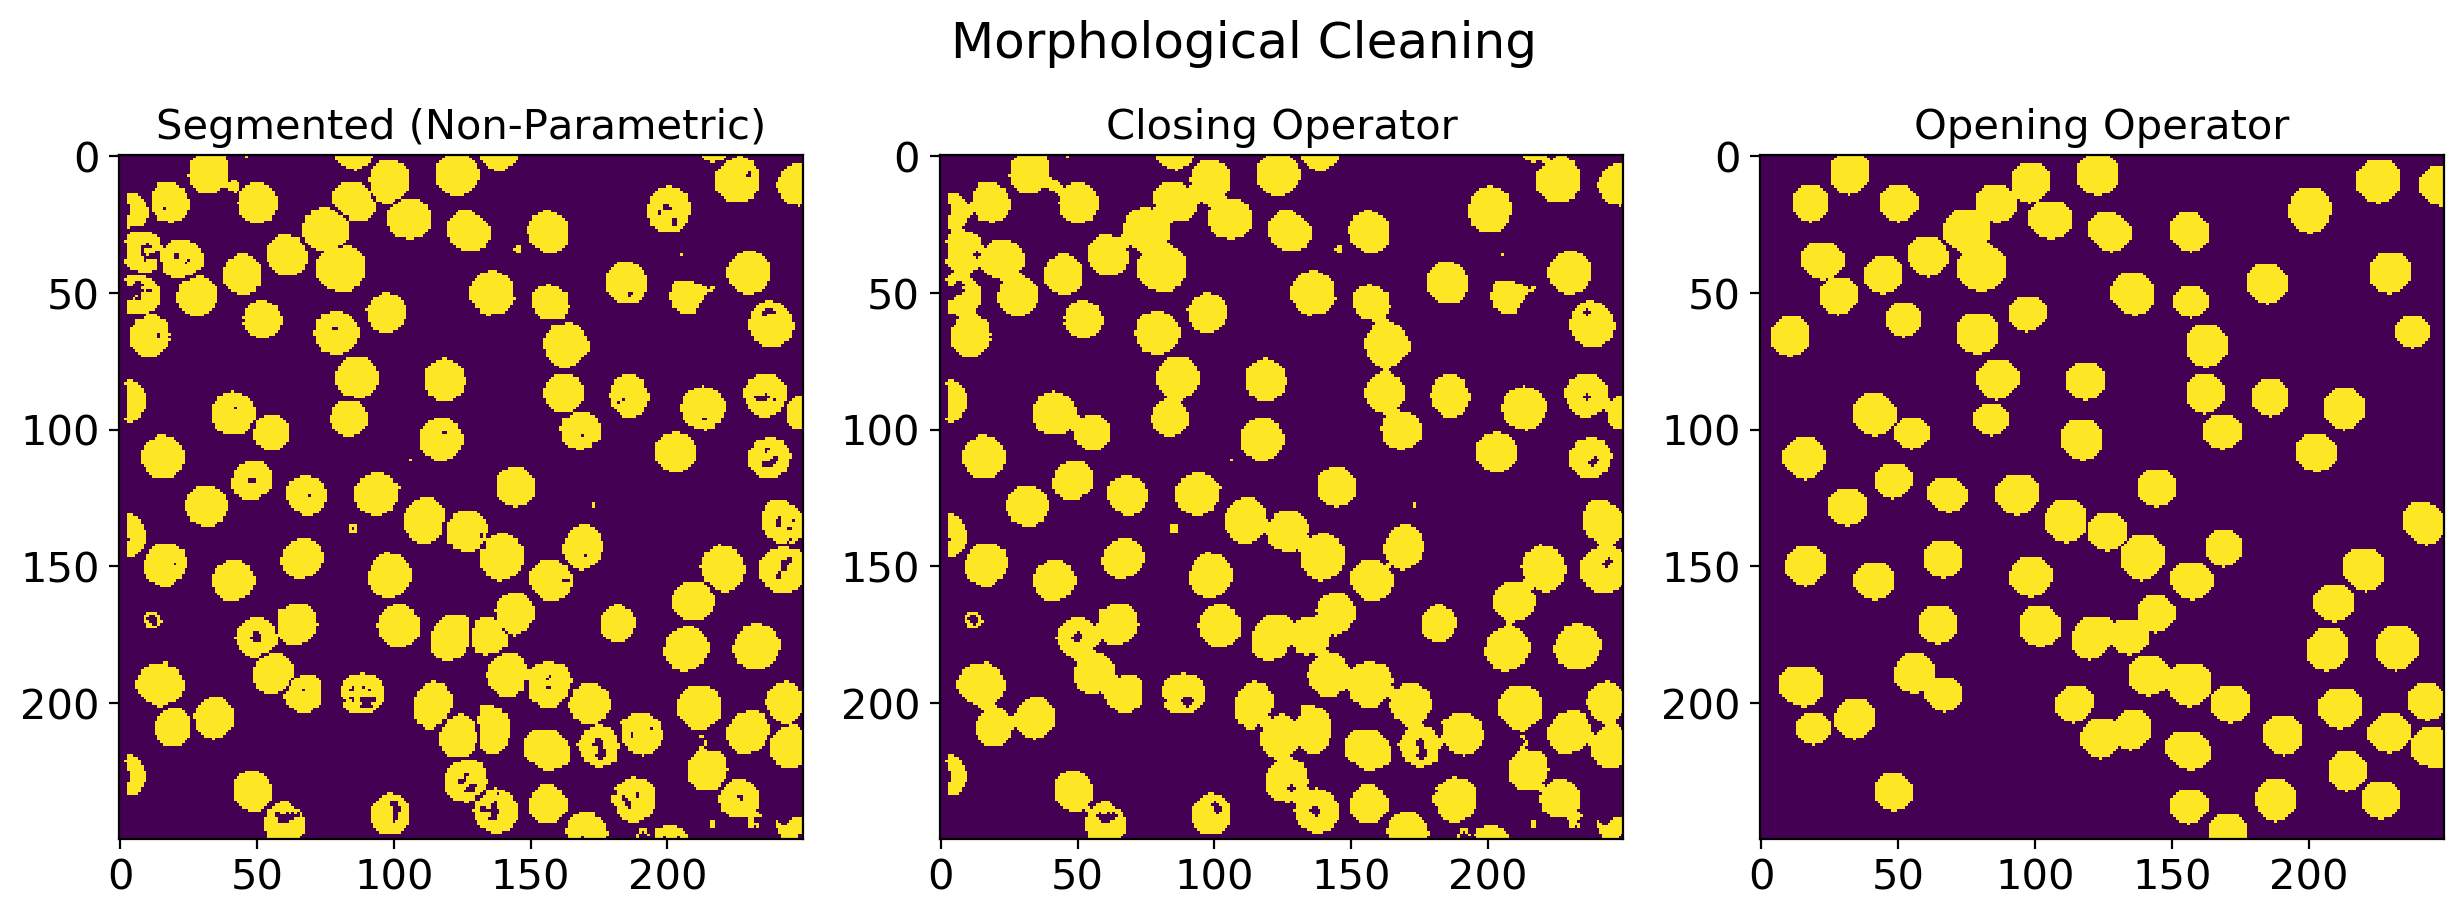

In [120]:
import cv2 as cv
Segmented = NPar

Segmented[Segmented<0.8]=0

#blobs = cv.morphologyEx(Segmented, cv.MORPH_OPEN, 
#                     cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))

plt.figure(figsize = [15,5], dpi = 200, facecolor = 'w')
plt.rcParams.update({'font.size' : 15})
plt.rcParams['axes.titlesize'] = 15

plt.suptitle("Morphological Cleaning")
plt.subplot(1,3,1)
plt.title("Segmented (Non-Parametric)")
plt.imshow(NPar)
plt.subplot(1,3,2)
plt.title("Closing Operator")
blobs = cv.morphologyEx(Segmented, cv.MORPH_CLOSE, 
                        cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
plt.imshow(blobs)
plt.subplot(1,3,3)
plt.title("Opening Operator")
blobs = cv.morphologyEx(blobs, cv.MORPH_OPEN, 
                        cv.getStructuringElement(cv.MORPH_ELLIPSE,(13,12)))
            
plt.imshow(blobs, alpha = 1)


In [107]:
region = measure.regionprops(A)
region.index(region[0])

0

Morphological Cleaning: https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

c:\users\rene\anaconda\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
c:\users\rene\anaconda\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


82


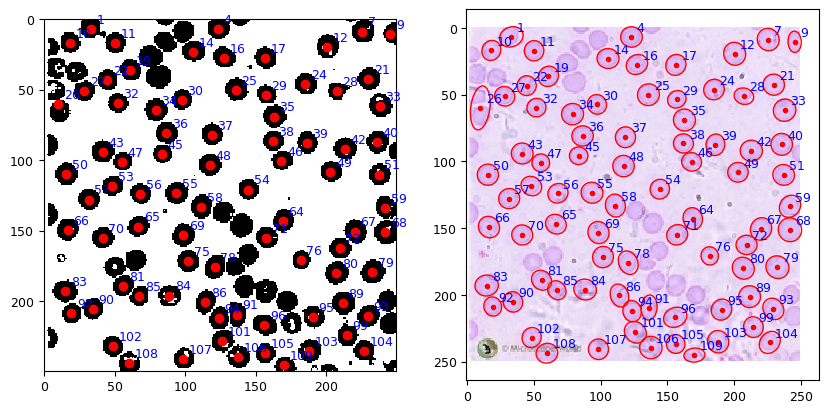

In [222]:
CLEAN = NPar
#CLEAN = blobs
#CLEAN = labels_ws

fig = plt.figure(figsize = [10,5], dpi = 100, facecolor = 'w')
plt.rcParams.update({'font.size' : 9})
plt.rcParams['axes.titlesize'] = 15
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
A = measure.label(CLEAN, neighbors=4)

CX = []
CY = []
AREA = []
MAJOR_AXIS = []
MINOR_AXIS = []
ECCENTRICITY = []
PERIMETER = []
for region in measure.regionprops(A):
    if 300 > region.area > 100:
        y, x = region.centroid
        CX.append(x)
        CY.append(y)
        
        AREA.append(region.area)
        ax1.imshow(CLEAN, cmap = 'gray_r')
        ax2.imshow(CELL, cmap = 'gray_r')
        ax1.plot(x,y, 'ro')  
        ax2.plot(x,y, 'r.')  
        major, minor = region.major_axis_length, region.minor_axis_length
        MAJOR_AXIS.append(major)
        MINOR_AXIS.append(minor)
        ECCENTRICITY.append(np.sqrt(major**2 - minor**2)/major)
        PERIMETER.append(2*np.pi*np.sqrt((major**2 + minor**2)/2))
        th = np.degrees(region.orientation)
        ellipse = patch.Ellipse((x, y), major, minor, th,
                             fill=False, ec='r', lw=1)
        #ax1.add_patch(ellipse)
        ax2.add_patch(ellipse)
        ax1.text(x+4,y-4,str(measure.regionprops(A).index(region)+1), color = "b")
        ax2.text(x+4,y-4,str(measure.regionprops(A).index(region)+1), color = "b")
        
print(len(AREA))

perimeter formula: https://www.mathsisfun.com/geometry/ellipse-perimeter.html

c:\users\rene\anaconda\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


182.20731707317074 25.708847203039284


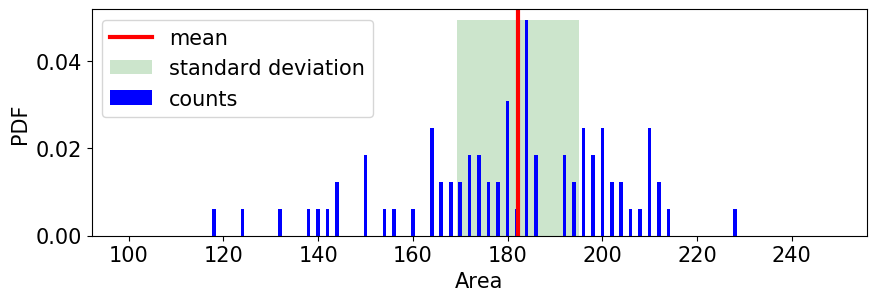

In [227]:
"AREA"

fig = plt.figure(figsize = [10,3], dpi = 100, facecolor = 'w')
plt.rcParams.update({'font.size' : 15})
plt.rcParams['axes.titlesize'] = 15
hist, bins = np.histogram(AREA, bins = 75, range = [100,250], normed = "True")
mean = np.mean(AREA)
std = np.std(AREA)
plt.gca().add_patch(patch.Rectangle((mean-std/2,0),std,max(hist), facecolor = 'g', alpha = 0.2))
plt.axvline(mean, color = 'r', lw = 3)
plt.bar(bins[:-1], hist, width=0.75, color='b')
#plt.grid()
plt.ylabel("PDF")
plt.xlabel("Area")
plt.legend(["mean", "standard deviation", "counts"], loc = 2)

print(mean, std)


In [141]:
std

25.708847203039284

c:\users\rene\anaconda\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


0.3782087467332129 0.1556147127084502


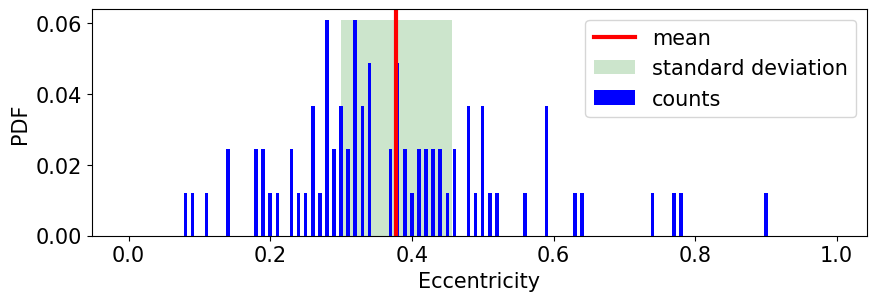

In [226]:
"ECCENTRICITY"

fig = plt.figure(figsize = [10,3], dpi = 100, facecolor = 'w')
plt.rcParams.update({'font.size' : 15})
plt.rcParams['axes.titlesize'] = 15
hist, bins = np.histogram(ECCENTRICITY, bins = 100, range = [0,1], normed = "True")
mean = np.mean(ECCENTRICITY)
std = np.std(ECCENTRICITY)
plt.gca().add_patch(patch.Rectangle((mean-std/2,0),std,max(hist/sum(hist)), facecolor = 'g', alpha = 0.2))
plt.axvline(mean, color = 'r', lw = 3)
plt.bar(bins[:-1], hist/sum(hist), width=0.005, color='b')
plt.ylabel("PDF")
plt.xlabel("Eccentricity")
plt.legend(["mean", "standard deviation", "counts"], loc = 1)

print(mean, std)


c:\users\rene\anaconda\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


16.333392925553596 2.151867289795934


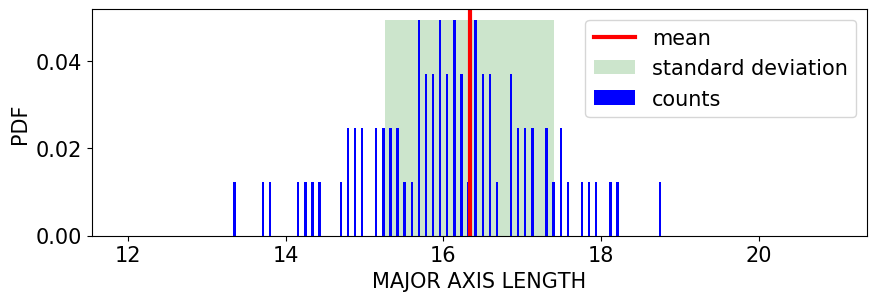

In [225]:
"MAJOR AXIS LENGTH"

fig = plt.figure(figsize = [10,3], dpi = 100, facecolor = 'w')
plt.rcParams.update({'font.size' : 15})
plt.rcParams['axes.titlesize'] = 15
hist, bins = np.histogram(MAJOR_AXIS, bins = 100, range = [12,21], normed = "True")
mean = np.mean(MAJOR_AXIS)
std = np.std(MAJOR_AXIS)
plt.gca().add_patch(patch.Rectangle((mean-std/2,0),std,max(hist/sum(hist)), facecolor = 'g', alpha = 0.2))
plt.axvline(mean, color = 'r', lw = 3)

plt.bar(bins[:-1], hist/sum(hist), width=0.03, color='b')
plt.ylabel("PDF")
plt.xlabel("MAJOR AXIS LENGTH")
plt.legend(["mean", "standard deviation", "counts"], loc = 1)

print(mean, std)


In [210]:
sum(hist)

4.44444444444444

97.83151669519859 9.218497926771365


c:\users\rene\anaconda\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


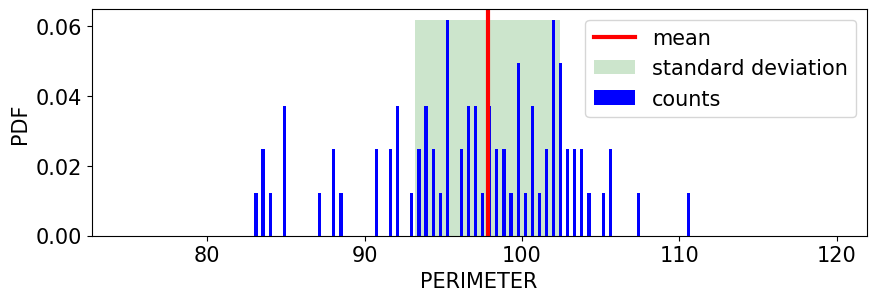

In [229]:
"PERIMETER"

fig = plt.figure(figsize = [10,3], dpi = 100, facecolor = 'w')
plt.rcParams.update({'font.size' : 15})
plt.rcParams['axes.titlesize'] = 15
hist, bins = np.histogram(PERIMETER, bins = 100, range = [75,120], normed = "True")
mean = np.mean(PERIMETER)
std = np.std(PERIMETER)
plt.gca().add_patch(patch.Rectangle((mean-std/2,0),std,max(hist/sum(hist)), facecolor = 'g', alpha = 0.2))
plt.axvline(mean, color = 'r', lw = 3)

plt.bar(bins[:-1], hist/sum(hist), width=0.2, color='b')
plt.ylabel("PDF")
plt.xlabel("PERIMETER")
print(mean, std)

plt.legend(["mean", "standard deviation", "counts"], loc = 1)



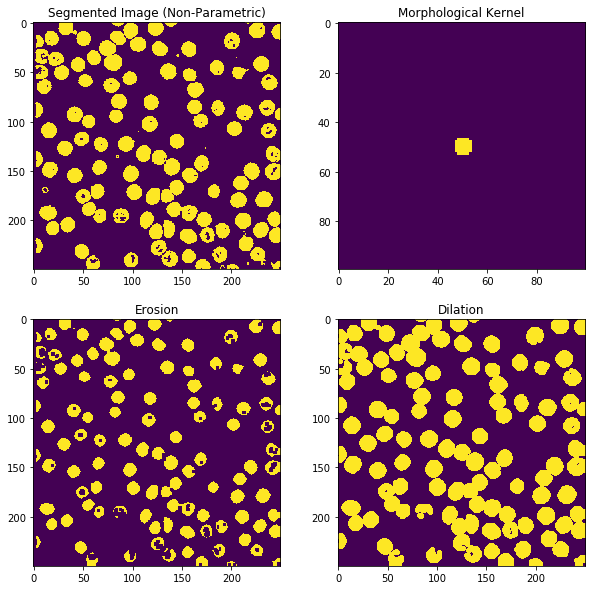

In [92]:
kernel = Circ(100,4)
kernel2 = Circ(100,3)

a = mp.erosion(NPar,Circ(10,1.5))
b = mp.dilation(a, Circ(100,2.3))
#b = mp.erosion(b, Circ(100,2.5))
#c = mp.dilation(b, Circ(100,1))
# a = mp.dilation(NPar,Circ(10,1.5))
# b = mp.erosion(a, Circ(10,1.5))
# c = mp.erosion(b, Circ(100,5))

plt.figure(figsize = [10,10])
plt.subplot(2,2,1)
plt.title("Segmented Image (Non-Parametric)")
plt.imshow(NPar)
plt.subplot(2,2,2)
plt.title("Morphological Kernel")
plt.imshow(kernel)
plt.subplot(2,2,3)
plt.title("Erosion")
plt.imshow(a)
plt.subplot(2,2,4)
plt.title("Dilation")
plt.imshow(b)
plt.show()

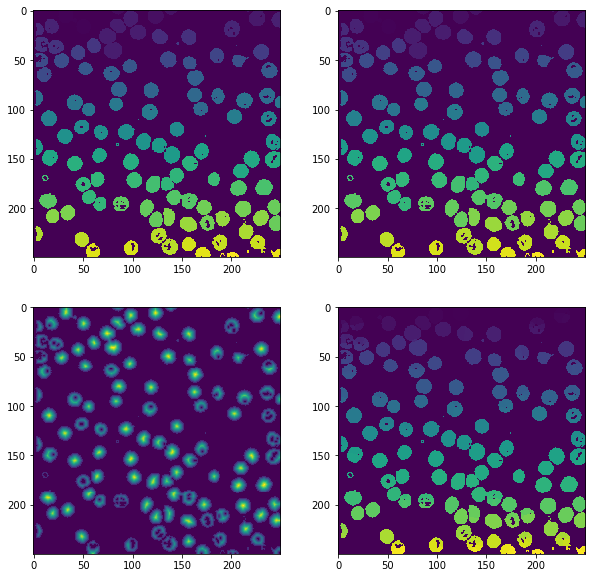

In [84]:
from skimage import measure, segmentation, morphology
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max
image = NPar

all_labels = measure.label(image)
blobs_labels = measure.label(image, background=0)
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

plt.figure(figsize = [10,10])
plt.subplot(2,2,1)
plt.imshow(all_labels)
plt.subplot(2,2,2)
plt.imshow(blobs_labels)
plt.subplot(2,2,3)
plt.imshow(distance)
plt.subplot(2,2,4)
plt.imshow(labels_ws)
#markers[~b] = -1
#labels_rw = segmentation.random_walker(image, markers)


In [90]:
ret,thresh = cv2.threshold(b.astype('uint8'),0,255,1)
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# CX, CY = [],[]
# for j in range(len(contours[:])):
#     cnt = contours[j]
#     M = cv2.moments(cnt)
#     cx = int(M['m10']/M['m00'])
#     cy = int(M['m01']/M['m00'])
#     CX.append(cx)
#     CY.append(cy)

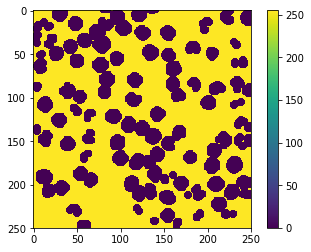

In [92]:
plt.imshow(thresh)
plt.colorbar()

In [93]:
contours_area = []
# calculate area and filter into new array
for con in contours:
    area = cv2.contourArea(con)
    contours_area.append(con)


In [103]:
help(cv2.contourArea)

Help on built-in function contourArea:

contourArea(...)
    contourArea(contour[, oriented]) -> retval
    .   @brief Calculates a contour area.
    .   
    .   The function computes a contour area. Similarly to moments , the area is computed using the Green
    .   formula. Thus, the returned area and the number of non-zero pixels, if you draw the contour using
    .   #drawContours or #fillPoly , can be different. Also, the function will most certainly give a wrong
    .   results for contours with self-intersections.
    .   
    .   Example:
    .   @code
    .   vector<Point> contour;
    .   contour.push_back(Point2f(0, 0));
    .   contour.push_back(Point2f(10, 0));
    .   contour.push_back(Point2f(10, 10));
    .   contour.push_back(Point2f(5, 4));
    .   
    .   double area0 = contourArea(contour);
    .   vector<Point> approx;
    .   approxPolyDP(contour, approx, 5, true);
    .   double area1 = contourArea(approx);
    .   
    .   cout << "area0 =" << area0 << endl <<

In [104]:
help(cv2.drawContours)

Help on built-in function drawContours:

drawContours(...)
    drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset]]]]]) -> image
    .   @brief Draws contours outlines or filled contours.
    .   
    .   The function draws contour outlines in the image if \f$\texttt{thickness} \ge 0\f$ or fills the area
    .   bounded by the contours if \f$\texttt{thickness}<0\f$ . The example below shows how to retrieve
    .   connected components from the binary image and label them: :
    .   @include snippets/imgproc_drawContours.cpp
    .   
    .   @param image Destination image.
    .   @param contours All the input contours. Each contour is stored as a point vector.
    .   @param contourIdx Parameter indicating a contour to draw. If it is negative, all the contours are drawn.
    .   @param color Color of the contours.
    .   @param thickness Thickness of lines the contours are drawn with. If it is negative (for example,
    .   thickness

In [73]:
# gray = cv2.cvtColor(CELL, cv2.COLOR_BGR2GRAY)
# t = 210
# blur = cv2.GaussianBlur(src = gray, ksize = (3,3), sigmaX = 1)
# (t, binary) = cv2.threshold(src = blur,
#     thresh = t, 
#     maxval = 255, 
#     type = cv2.THRESH_BINARY)
# plt.imshow(binary)

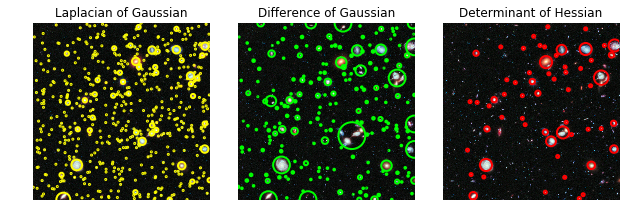